$$
\alpha(\theta) = (1 + \frac{\alpha_{\text{min}}}{2}) + (1 - \frac{\alpha_{\text{min}}}{2}) \cos(\frac{\theta}{\theta_{\text{min}}}\pi)
$$

$$
\Delta T(\theta) = 
\begin{cases}
    -\frac{a}{c}\cos(\theta), & \text{if } 0 \le |\theta| < \frac{\pi}{2}\\
    \frac{a}{c}(|\theta|-\frac{\pi}{2}), & \text{if } \frac{\pi}{2} \le |\theta| < \pi \\
\end{cases}
$$

$$
\begin{align}
H_{HS}(\omega, \theta) 
&= \frac{1+j\frac{\alpha \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} \\
&= \frac{1+\frac{j \alpha a 2 \pi f}{c}}{1+\frac{j a 2 \pi f}{c}} \\
\end{align}
$$

$$
H_H(\omega, \theta) = \frac{1+j\frac{\alpha(\theta - \theta_{\text{ear}}) \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} e^{-j \omega T_d(\theta - \theta_{\text{ear}})}\\
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, sosfilt, sosfreqz, bilinear

In [2]:
def compute_t(theta, a = 0.0875, c = 343):
    if 0 <= np.abs(theta) < np.pi / 2:
        return -a / c * np.cos(theta)
    elif np.pi / 2 <= np.abs(theta) < np.pi / 2:
        return a / c * (np.abs(theta) - np.pi / 2)
    else:
        return NotImplementedError

def compute_alpha(theta, alpha_min = 0.1, theta_min = 150):
    alpha = (1 + alpha_min * 0.5) + (1 - alpha_min * 0.5) * np.cos(theta * np.pi / theta_min)
    return alpha
    
def compute_transfer_function(theta, alpha_min = 0.1, theta_min = 150, a = 0.0875, c = 343):
    alpha = compute_alpha(theta, alpha_min, theta_min)

    f = np.arange(1, 1001) * c / (2 * np.pi * a)
    f = f / 10 # range from 0.1 to 100
    
    pole = alpha * a * np.pi * f / c
    zero = a * np.pi * f / c

    num = 1 + 1j * pole
    den = 1 + 1j * zero
    
    Hs = num / den
    
    return Hs

Based on the equations provided, the transfer function $H_{HS}(\omega, \theta) $ is derived and approximated in the z-domain as follows:

$$
\begin{align}
H_{HS}(\omega, \theta) 
&= \frac{1+j\frac{\alpha \omega}{2 \omega_0}}{1+j\frac{\omega}{2 \omega_0}} \\
&= \frac{1+\frac{\alpha}{2 \omega_0}s}{1+\frac{1}{2 \omega_0}s} \\
&\approx \frac{1+\frac{\alpha}{2 \omega_0}\frac{2}{T} \frac{z-1}{z+1}}{1+\frac{1}{2 \omega_0}\frac{2}{T} \frac{z-1}{z+1}} \\
&= \frac{1+\frac{\alpha}{\omega_0}\frac{1}{T} \frac{z-1}{z+1}}{1+\frac{1}{\omega_0}\frac{1}{T} \frac{z-1}{z+1}} \\
&= \frac{\omega_0 T (z+1) + \alpha (z-1)}{ \omega_0 T (z+1) + (z-1) } \\
&= \frac{\alpha + \omega_0 T - ( \alpha - \omega_0 T )z^{-1}}{1 + \omega_0 T - ( 1 - \omega_0 T )z^{-1} } \\
&= \frac{\frac{\alpha + \frac{\omega_0}{sr}}{1 + \frac{\omega_0}{sr}} - \frac{\alpha - \frac{\omega_0}{sr}}{1 + \frac{\omega_0}{sr}}z^{-1}}
{1 - \frac{1 - \frac{\omega_0}{sr}}{1 + \frac{\omega_0}{sr}}z^{-1}}
\end{align}
$$

In [3]:
def compute_transfer_function_z(theta, alpha_min = 0.1, theta_min = 180, a = 0.0875, c = 343, sr = 44100):
    alpha = compute_alpha(theta, alpha_min, theta_min)
    w0 = c / a

    b = [(alpha+w0/sr)/(1+w0/sr), -(alpha-w0/sr)/(1+w0/sr)]
    a = [1, -(1-w0/sr)/(1+w0/sr)]
    
    return b, a

$$
\frac{H_\text{front}}{H_\text{rear}} = \frac{\frac{H_{b_\text{front}}}{H_{a_\text{front}}}}{\frac{H_{b_\text{rear}}}{H_{a_\text{rear}}}} = \frac{H_{b_\text{front}}H_{a_\text{rear}}}{H_{a_\text{front}}H_{b_\text{rear}}}
$$

<img align="center" width=50% src="spk2spk_dist_inc_dec-Page-0.drawio.png" alt>

In [4]:
spk_2_spk_dist = 40
aud_2_spk_dist = 15

# Calculate the angle in radians using arctan
angle_rad = np.arctan(spk_2_spk_dist * 0.5 / aud_2_spk_dist)

# Convert the angle to degrees
angle_deg = np.degrees(angle_rad)

# Convert to interaural system
rear_interaural = 180 - angle_deg

If the speaker span is undefined, the following frequency response curves are shown at every 5-degree interval(5°-60°).

<img align="center" width=50% src="spk2spk_dist_inc_dec-Page-1.drawio.png" alt>

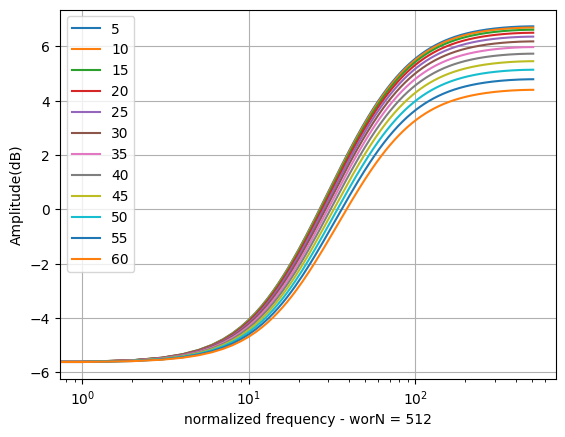

In [5]:
for index in range(12):
    front_interaural = index * 5 + 5
    b_r, a_r = compute_transfer_function_z(rear_interaural)
    b_f, a_f = compute_transfer_function_z(front_interaural)

    b = np.convolve(b_f, a_r)
    a = np.convolve(a_f, b_r)

    # the stability of the coefficients
    a = a / a[0]
        
    stability = np.max(np.abs(np.roots(a)))
    assert stability < 0.99999, f'unstable poles for XTC filter!! max = {stability}'

    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(index*5+5))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()

In [6]:
# Assume the speaker span is fixed
front_interaural = 30

If the head rotates counterclockwise, here is the frequency response curve at every 5-degree interval.

<img align="center" width=50% src="spk2spk_dist_inc_dec-Page-2.drawio.png" alt>

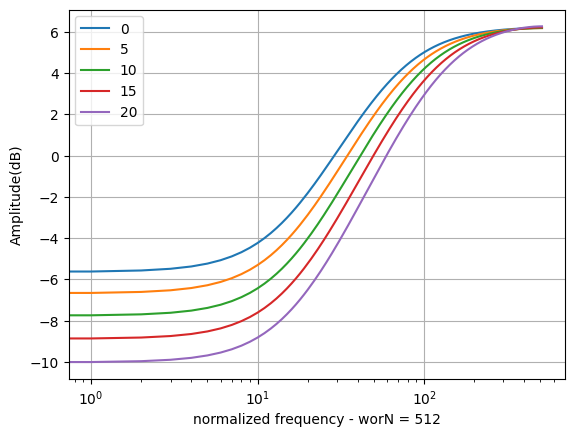

In [7]:
# Head rotates in counterclockwise

for inc in range(5):
    front_interaural_rotate = front_interaural + inc * 5
    rear_interaural_rotate = rear_interaural + inc * 5
    b_r, a_r = compute_transfer_function_z(rear_interaural_rotate)
    b_f, a_f = compute_transfer_function_z(front_interaural_rotate)

    b = np.convolve(b_f, a_r)
    a = np.convolve(a_f, b_r)

    # the stability of the coefficients
    a = a / a[0]
        
    stability = np.max(np.abs(np.roots(a)))
    assert stability < 0.99999, f'unstable poles for XTC filter!! max = {stability}'

    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(inc*5))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()

If the head rotates anti-counterclockwise, here is the frequency response curve at every 5-degree interval.

<img align="center" width=50% src="spk2spk_dist_inc_dec-Page-3.drawio.png" alt>

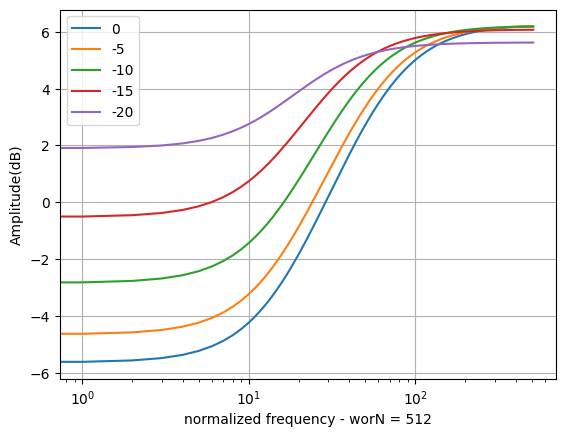

In [8]:
# Head rotates in anti-counterclockwise

for dec in range(5):
    front_interaural = front_interaural - dec * 5
    rear_interaural = rear_interaural - dec * 5
    b_r, a_r = compute_transfer_function_z(rear_interaural)
    b_f, a_f = compute_transfer_function_z(front_interaural)

    b = np.convolve(b_f, a_r)
    a = np.convolve(a_f, b_r)

    # the stability of the coefficients
    a = a / a[0]
        
    stability = np.max(np.abs(np.roots(a)))
    assert stability < 0.99999, f'unstable poles for XTC filter!! max = {stability}'

    w, h = freqz(b, a)
    a = 20 * np.log10(np.abs(h))
    plt.plot(a, label = str(-dec*5))

plt.grid(True)
plt.legend()
plt.xscale('log')
plt.ylabel("Amplitude(dB)")
plt.xlabel("normalized frequency - worN = 512")
plt.show()